In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, Activation, add
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/tambet/.conda/envs/pommer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [3]:
data = np.load('single_600K_disc0.9.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((600000, 11, 11, 18), (600000,), (600000,))

In [4]:
data = np.load('valid_single_80K_disc0.9.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((80000, 11, 11, 18), (80000,), (80000,))

In [5]:
def ConvBlock(mod):
    mod = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    return mod

def ResidualBlock(mod):
    tmp = mod
    mod = ConvBlock(mod)
    mod = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = add([mod,tmp])
    mod = Activation('relu')(mod)
    return mod

def PolicyHead(mod):
    mod = Conv2D(filters=2, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(6, activation='softmax', name='p')(mod)
    return mod

def ValueHead(mod):
    mod = Conv2D(filters=1, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(256)(mod)
    mod = Activation('relu')(mod)
    mod = Dense(1)(mod)
    mod = Activation('tanh',name='v')(mod)
    return mod

h = x = Input(shape=(11,11,18))
h = ConvBlock(h)
for i in range(20):
    h = ResidualBlock(h)
p = PolicyHead(h)
v = ValueHead(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 32)   5216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11, 11, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 11, 11, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
callbacks = [
    ModelCheckpoint('agz20_single_value10_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
]

In [7]:
history = model.fit(x_train, [p_train, v_train], batch_size=512, epochs=100, validation_data=(x_test, [p_test, v_test]), callbacks=callbacks)

Train on 600000 samples, validate on 80000 samples
Epoch 1/100
600000/600000 [==============================] - 546s 910us/step - loss: 1.5602 - p_loss: 1.2308 - v_loss: 0.0329 - p_acc: 0.4773 - val_loss: 1.2257 - val_p_loss: 0.9545 - val_v_loss: 0.0271 - val_p_acc: 0.5931

Epoch 00001: val_loss improved from inf to 1.22570, saving model to agz20_single_value10_best.h5
Epoch 2/100
600000/600000 [==============================] - 559s 931us/step - loss: 0.9928 - p_loss: 0.7429 - v_loss: 0.0250 - p_acc: 0.6790 - val_loss: 0.9780 - val_p_loss: 0.7319 - val_v_loss: 0.0246 - val_p_acc: 0.6895

Epoch 00002: val_loss improved from 1.22570 to 0.97805, saving model to agz20_single_value10_best.h5
Epoch 3/100
600000/600000 [==============================] - 559s 931us/step - loss: 0.8223 - p_loss: 0.5908 - v_loss: 0.0231 - p_acc: 0.7305 - val_loss: 0.8994 - val_p_loss: 0.6675 - val_v_loss: 0.0232 - val_p_acc: 0.7121

Epoch 00003: val_loss improved from 0.97805 to 0.89941, saving model to agz20_s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600000/600000 [==============================] - 516s 860us/step - loss: 0.6328 - p_loss: 0.4574 - v_loss: 0.0175 - p_acc: 0.7770 - val_loss: 0.7248 - val_p_loss: 0.5058 - val_v_loss: 0.0219 - val_p_acc: 0.7524

Epoch 00016: val_loss did not improve from 0.71813
Epoch 17/100
600000/600000 [==============================] - 516s 860us/step - loss: 0.6258 - p_loss: 0.4545 - v_loss: 0.0171 - p_acc: 0.7790 - val_loss: 0.7775 - val_p_loss: 0.5343 - val_v_loss: 0.0243 - val_p_acc: 0.7530

Epoch 00017: val_loss did not improve from 0.71813
Epoch 00017: early stopping


Text(0.5,1,'Value MSE')

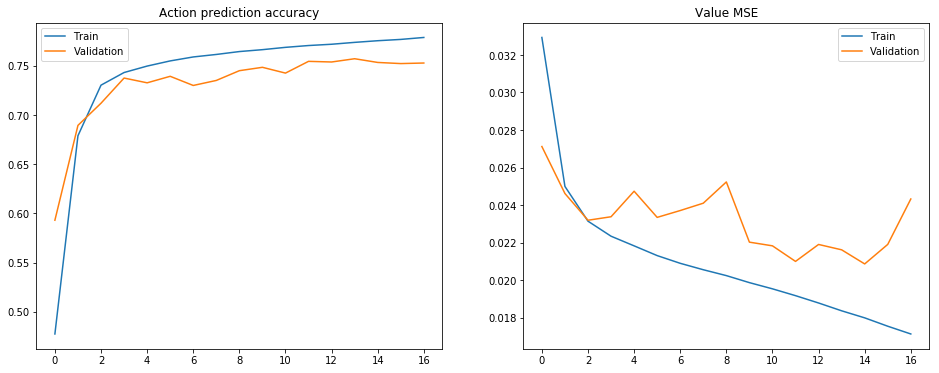

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [9]:
model.save('agz20_single_value10_disc0.9_final.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.7708783333333333
Accuracy test: 0.7529625
Explained variance train: 0.6592071131540008
Explained variance test: 0.5763492337347254


In [11]:
model = load_model('agz20_single_value10_disc0.9_best.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.7725333333333333
Accuracy test: 0.7546625
Explained variance train: 0.6591889182439277
Explained variance test: 0.613236875848116
